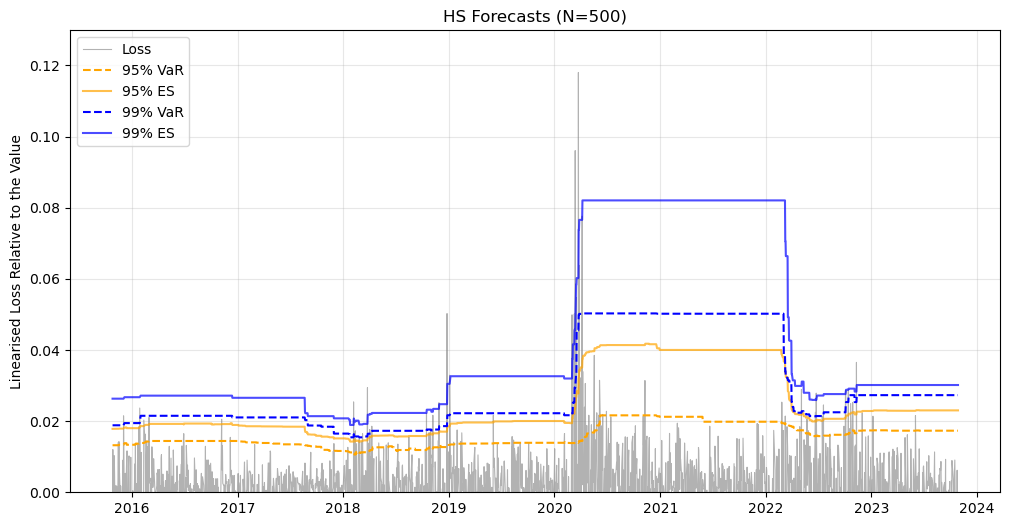

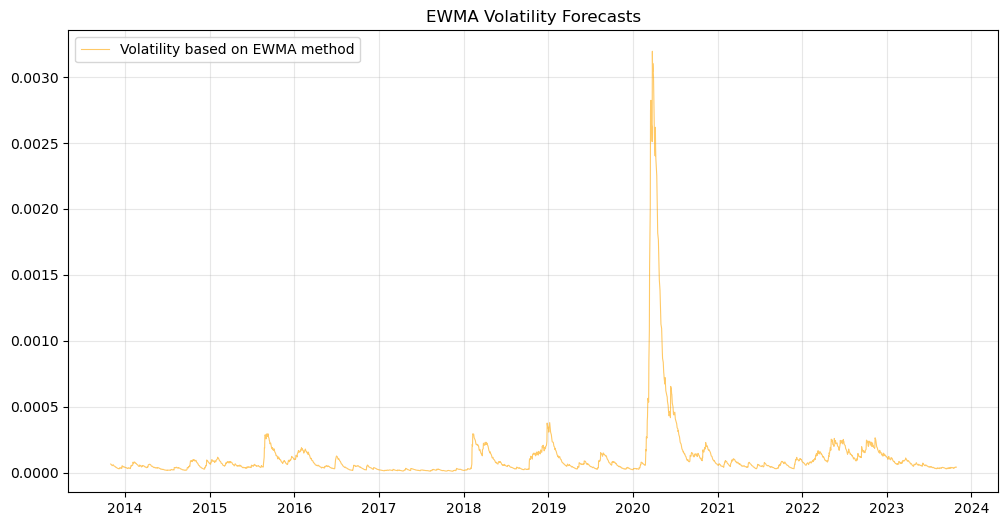

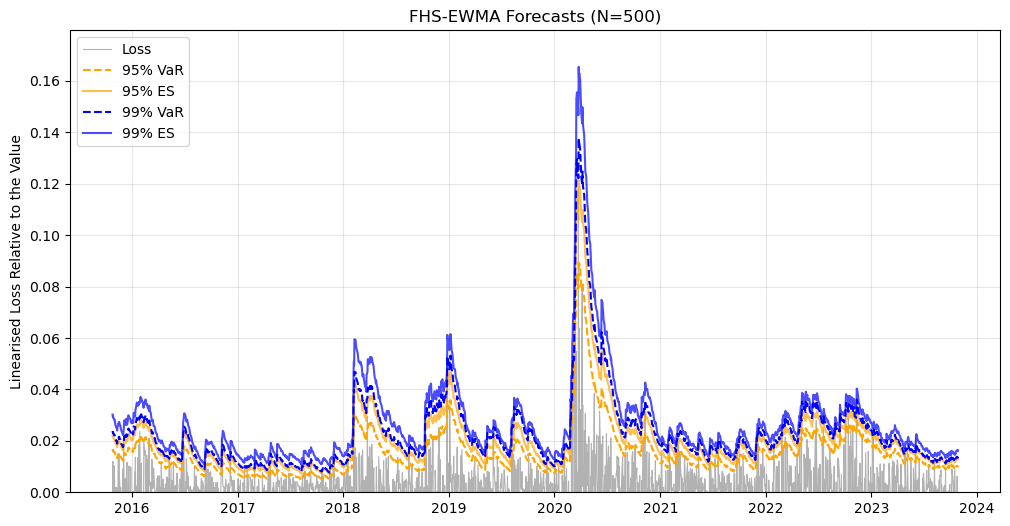

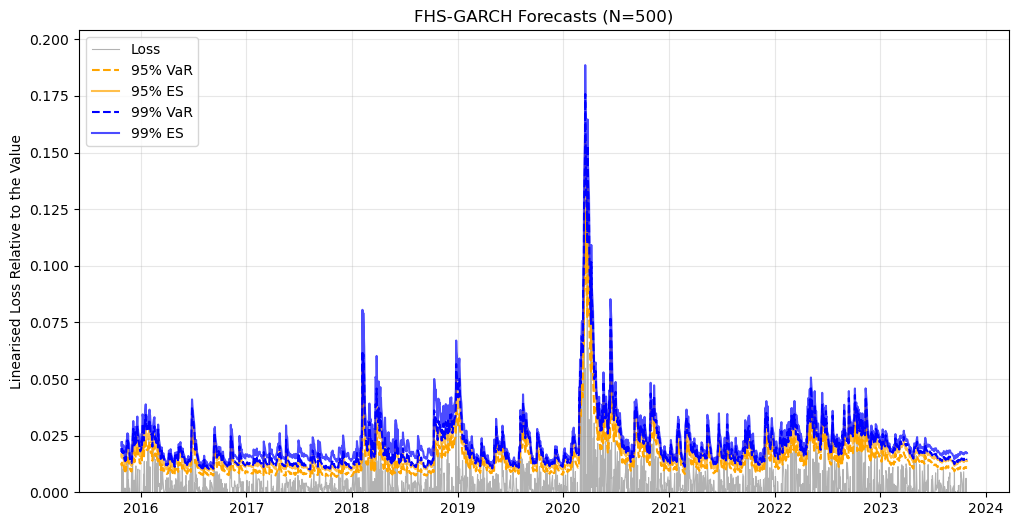

    Model alpha    LR_uc     p_uc
       HS   95% 0.032174 0.857646
       HS   99% 4.228302 0.039755
 FHS-EWMA   95% 0.032174 0.857646
 FHS-EWMA   99% 0.389410 0.532610
FHS-GARCH   95% 0.000652 0.979621
FHS-GARCH   99% 3.456630 0.062999
    Model alpha    LR_uc    p_ind
       HS   95% 4.722207 0.029776
       HS   99% 3.055690 0.080455
 FHS-EWMA   95% 0.180671 0.670797
 FHS-EWMA   99% 0.531409 0.466015
FHS-GARCH   95% 2.612224 0.106043
FHS-GARCH   99% 0.847393 0.357291
    Model alpha    LR_uc     p_cc
       HS   95% 4.754381 0.092811
       HS   99% 7.283992 0.026200
 FHS-EWMA   95% 0.212845 0.899045
 FHS-EWMA   99% 0.920819 0.631025
FHS-GARCH   95% 2.612876 0.270783
FHS-GARCH   99% 4.304023 0.116250


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from arch import arch_model
from scipy.stats import chi2

def es(window, alpha):
    var = window.quantile(alpha)
    return window[window >= var].mean()

### Initialisation
df = pd.read_csv('../data/QRM-2025-cw1-data-b.csv')
prices = df['Adj Close'].values
dates = pd.to_datetime(df['Date'], dayfirst=True).values[1:]
losses = -np.log(prices[1:] / prices[:-1])
T = len(losses)

### Common HS Setup
N = 500
targets = losses[N:]
target_dates = dates[N:]


### Part (i)
windows = sliding_window_view(losses[:-1], window_shape=N) # Technical reason to exclude the last date

var_95_i = np.quantile(windows, 0.95, axis=1)
es_95_i = np.array([w[w >= v].mean() for w, v in zip(windows, var_95_i)])

var_99_i = np.quantile(windows, 0.99, axis=1)
es_99_i = np.array([w[w >= v].mean() for w, v in zip(windows, var_99_i)])


plt.figure(figsize=(12, 6))
plt.plot(target_dates, targets, 'gray', alpha=0.6, lw=0.8, label='Loss')
plt.plot(target_dates, var_95_i, 'orange', linestyle='--', label='95% VaR')
plt.plot(target_dates, es_95_i, 'orange', alpha=0.7, label='95% ES')
plt.plot(target_dates, var_99_i, 'blue', linestyle='--', label='99% VaR')
plt.plot(target_dates, es_99_i, 'blue', alpha=0.7, label='99% ES')
plt.ylim(bottom=0) # Only include positive losses
plt.title(f'HS Forecasts (N={N})')
plt.ylabel('Linearised Loss Relative to the Value')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.savefig('assets/hs.png')
plt.show()

### Part (ii)
sigma2 = np.zeros(T)
sigma2[0] = np.var(losses[:N]) # Take variance as initial condition (DUE TO DISCUSS）

# Run EWMA
for t in range(1, T):
    sigma2[t] = (1 - 0.06) * sigma2[t-1] + 0.06 * losses[t-1]**2
sigma = np.sqrt(sigma2)
plt.figure(figsize=(12, 6))
plt.plot(dates, sigma2, 'orange', alpha=0.6, lw=0.8, label='Volatility based on EWMA method')
plt.title('EWMA Volatility Forecasts')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.savefig('assets/ewma_vol.png')
plt.show()

std_residuals = losses / sigma # Assume mean is zero (DUE TO DISCUSS)
windows = sliding_window_view(std_residuals[:-1], window_shape=N)
vols = sigma[N:]

var_95_z_ii = np.quantile(windows, 0.95, axis=1)
es_95_z_ii = np.array([w[w >= v].mean() for w, v in zip(windows, var_95_z_ii)])
var_95_ii = vols * var_95_z_ii
es_95_ii = vols * es_95_z_ii

var_99_z_ii = np.quantile(windows, 0.99, axis=1)
es_99_z_ii = np.array([w[w >= v].mean() for w, v in zip(windows, var_99_z_ii)])
var_99_ii = vols * var_99_z_ii
es_99_ii = vols * es_99_z_ii

plt.figure(figsize=(12, 6))
plt.plot(target_dates, targets, 'gray', alpha=0.6, lw=0.8, label='Loss')
plt.plot(target_dates, var_95_ii, 'orange', linestyle='--', label='95% VaR')
plt.plot(target_dates, es_95_ii, 'orange', alpha=0.7, label='95% ES')
plt.plot(target_dates, var_99_ii, 'blue', linestyle='--', label='99% VaR')
plt.plot(target_dates, es_99_ii, 'blue', alpha=0.7, label='99% ES')
plt.ylim(bottom=0) # Only include positive losses
plt.title(f'FHS-EWMA Forecasts (N={N})')
plt.ylabel('Linearised Loss Relative to the Value')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.savefig('assets/fhs_ewma.png')
plt.show()

### Part (iii)
windows = sliding_window_view(losses[:-1], window_shape=N)
var_95_iii = np.zeros(T-N)
es_95_iii = np.zeros(T-N)
var_99_iii = np.zeros(T-N)
es_99_iii = np.zeros(T-N)
for i in range(T-N):
    am = arch_model(windows[i] * 100, mean='Constant', vol='Garch', p=1, q=1, dist='normal')
    res = am.fit(update_freq=0, disp='off')
    
    std_residuals = res.std_resid
    
    var_95_z_iii = np.quantile(std_residuals, 0.95)
    es_95_z_iii = std_residuals[std_residuals >= var_95_z_iii].mean()
    
    var_99_z_iii = np.quantile(std_residuals, 0.99)
    es_99_z_iii = std_residuals[std_residuals >= var_99_z_iii].mean()
    
    forecast = res.forecast(horizon=1)
    
    mu_forecast = forecast.mean.iloc[-1].values[0] / 100.0
    sigma_forecast = np.sqrt(forecast.variance.iloc[-1].values[0]) / 100.0

    var_95_iii[i] = mu_forecast + sigma_forecast * var_95_z_iii
    es_95_iii[i] = mu_forecast + sigma_forecast * es_95_z_iii
    
    var_99_iii[i] = mu_forecast + sigma_forecast * var_99_z_iii
    es_99_iii[i] = mu_forecast + sigma_forecast * es_99_z_iii
    
plt.figure(figsize=(12, 6))
plt.plot(target_dates, targets, 'gray', alpha=0.6, lw=0.8, label='Loss')
plt.plot(target_dates, var_95_iii, 'orange', linestyle='--', label='95% VaR')
plt.plot(target_dates, es_95_iii, 'orange', alpha=0.7, label='95% ES')
plt.plot(target_dates, var_99_iii, 'blue', linestyle='--', label='99% VaR')
plt.plot(target_dates, es_99_iii, 'blue', alpha=0.7, label='99% ES')
plt.ylim(bottom=0) # Only include positive losses
plt.title(f'FHS-GARCH Forecasts (N={N})')
plt.ylabel('Linearised Loss Relative to the Value')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.savefig('assets/fhs_garch.png')
plt.show()

### Backtesting
# Violations
v_95_i = targets > var_95_i
v_99_i = targets > var_99_i
v_95_ii = targets > var_95_ii
v_99_ii = targets > var_99_ii
v_95_iii = targets > var_95_iii
v_99_iii = targets > var_99_iii

def backtest(violations, alpha):
    
    T = len(violations)
    N1 = np.sum(violations)
    N0 = T - N1
    eps = 1e-15 # Prevent divide by zero
    
    # Unconditional Coverage
    pi = N1 / T
    
    logL_H0 = N0 * np.log(alpha) + N1 * np.log(1-alpha)
    logL_H1 = N0 * np.log(1 - pi) + N1 * np.log(pi)
    LR_uc = -2 * (logL_H0 - logL_H1)
    p_uc = 1 - chi2.cdf(LR_uc, 1)

    # Independence
    t00, t01, t10, t11 = 0, 0, 0, 0
    for i in range(1, T):
        if not violations[i-1] and not violations[i]: t00 += 1
        if not violations[i-1] and violations[i]: t01 += 1
        if violations[i-1] and not violations[i]: t10 += 1
        if violations[i-1] and violations[i]: t11 += 1

    pi01 = t01 / (t00 + t01)
    pi11 = t11 / (t10 + t11)
    
    logL_H0 = (t00 + t10) * np.log(1 - pi + eps) + (t01 + t11) * np.log(pi + eps)
    logL_H1 = t00 * np.log(1 - pi01 + eps) + t01 * np.log(pi01 + eps) + t10 * np.log(1 - pi11 + eps) + t11 * np.log(pi11 + eps)
    
    LR_ind = -2 * (logL_H0 - logL_H1)
    p_ind = 1 - chi2.cdf(LR_ind, 1)

    # Joint
    LR_cc = LR_uc + LR_ind
    p_cc = 1.0 - chi2.cdf(LR_cc, 2)

    return LR_uc, p_uc, LR_ind, p_ind, LR_cc, p_cc

models = [
    ('HS', '95%', v_95_i, 0.95),
    ('HS', '99%', v_99_i, 0.99),
    ('FHS-EWMA', '95%', v_95_ii, 0.95),
    ('FHS-EWMA', '99%', v_99_ii, 0.99),
    ('FHS-GARCH', '95%', v_95_iii, 0.95),
    ('FHS-GARCH', '99%', v_99_iii, 0.99),
]
results_uc = []
results_ind = []
results_cc = []
for name, alpha_str, violations, alpha_val in models:
    LR_uc, p_uc, LR_ind, p_ind, LR_cc, p_cc = backtest(violations, alpha_val)
    results_uc.append({
        'Model': name,
        'alpha': alpha_str,
        'LR_uc': LR_uc,
        'p_uc': p_uc
    })
    results_ind.append({
        'Model': name,
        'alpha': alpha_str,
        'LR_uc': LR_ind,
        'p_ind': p_ind
    })
    results_cc.append({
        'Model': name,
        'alpha': alpha_str,
        'LR_uc': LR_cc,
        'p_cc': p_cc
    })
df_results_uc = pd.DataFrame(results_uc)
df_results_ind = pd.DataFrame(results_ind)
df_results_cc = pd.DataFrame(results_cc)
print(df_results_uc.to_string(index=False))
print(df_results_ind.to_string(index=False))
print(df_results_cc.to_string(index=False))
